In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## I ran a conda install -c conda-forge contextily


In [6]:
s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/")

['veda-data-store-staging/EIS/other/station-FWI/20000101.20220907.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20000101.20220919.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20000101.20220930.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20000101.20221021.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20170101.20221231.hrlyInterp',
 'veda-data-store-staging/EIS/other/station-FWI/20180101.20221028.hrlyInterp']

In [2]:
## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019

st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map, path_s3 = "veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/


In [35]:
## Choose a fire

In [36]:
#gdf = fv.load_file( date = "20201022PM", layer = "perimeter",   handle_multi=False,only_lf = False,area_lim = 4.7, year = "2020", path_region = "WesternUS")
#gdf.set_index('fireID',inplace=True)

### Get explore map to display lat and lon 
# gdf_test = gdf ## Default crs seems to be easting and westing in just US. reproject to lat vs lon

# gdf_test = gdf_test.to_crs('EPSG:4326')
# gdf_test['lon'] = gdf_test.centroid.x
# gdf_test['lat'] = gdf_test.centroid.y

# gdf_test["t"] = gdf_test["t"].astype("str")
# gdf_test["t_st"] = gdf_test["t_st"].astype("str")
# gdf_test["t_ed"] = gdf_test["t_ed"].astype("str")
# gdf_test.explore()

In [3]:
def open_largefire_gdf(fireID, year = "2020", path_region = "WesternUS"):
    gdf_beachie = fv.load_large_fire(fireID = fireID, year = year, path_region = path_region )

    gdf_beachie = gdf_beachie.to_crs('EPSG:4326')
    gdf_beachie['lon'] = gdf_beachie.centroid.x
    gdf_beachie['lat'] = gdf_beachie.centroid.y

    gdf_beachie["t"] = gdf_beachie["t"].astype("str")
    #gdf_beachie["t_st"] = gdf_beachie["t_st"].astype("str")
    #gdf_beachie["t_ed"] = gdf_beachie["t_ed"].astype("str")
    
    return(gdf_beachie)
def fr_st_merge(gdf, dat, sub= True, sub_type = "exact", num_months = 1, custom_date = "NA", end_date = "2020-10-08"):
    '''
    INPUTS:
        gdf (GeoDataFrame): A largefile GeoDataFrame as read in by load_large_fire.
        dat (DataFrame): Station data, as read in by get_st
        sub (bool): Will subset the station data to dates overlapping the time when the fire is active (according to Yang Chen's algorithm, ~ 5 days past last burn)
        sub_type (str): "exact", "month_before", Subset station data to include leadup to fire
        num_months (int): If sub_type = "month_before", # months before start of fire. 
    '''
    
    if(sub):
        if(sub_type == "exact"):
            st_dat = dat[(dat.time >= min(gdf.t)) &  (dat.time <= max(gdf.t))]
        if(sub_type == "month_before"):
            start_date =  min(gdf.t)
            month_early = start_date - np.timedelta64(num_months, 'M')

            st_dat = dat[(dat.time >= month_early) &  (dat.time <= max(gdf.t))]
        if(sub_type == "custom"):
            start_date =  min(gdf.t)
            print("Subsetting to ", custom_date, "through", end_date)
            st_dat = dat[(dat.time >= custom_date) & (dat.time <= end_date)]
        
    else:
        st_dat = dat
   
    st_dat = st_dat.rename(columns = {"time":"t"}) 
    
    ## Put both into datetimes
    st_dat['t'] = st_dat['t'].astype('datetime64[ns]')
    gdf['t'] = gdf['t'].astype('datetime64[ns]')
    full = pd.merge(gdf,st_dat, on = "t", how = "outer")
    #full = full.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
    #full['t'] = full['t'].astype('datetime64[ns]') 
    return(full)

def merge_with_fire(gdf_beachie, fireID = "NA", fire_name = "NA", not_custom = True, foi_custom = "NA" ):
    ## Clean some columns
    gdf_beachie["fireID"] = fireID
    gdf_beachie["Fire_Name"] = fire_name
    gdf_beachie["timediff"]  = gdf_beachie.t.astype("datetime64[ns]") - pd.to_datetime(min(gdf_beachie.t))
    gdf_beachie['timediff'] = gdf_beachie.timediff.astype("int")
    
    ## Get Fire Lat Lon
    if(not_custom):
        foi = gdf_beachie
        foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
        foi = foi.iloc[0] # First element
        print(foi["Lat"])
        print(foi["Lon"])
    else:
        foi = foi_custom
        print(foi["Lat"])
        print(foi["Lon"])
        
    ## Look for closest station
    st_cls = closest(st_dict, foi)
    closest(st_dict,foi)
    
    ## Get station Data
    st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)
    
    ## Merge with fire data
    gdf_beachie["t"] = gdf_beachie["t"].astype("datetime64[ns]")
    full_fr = fr_st_merge(gdf_beachie, st, sub = True, sub_type = "custom", custom_date = "2020-08-08", end_date = "2020-10-08")
    full_fr = full_fr.sort_values( by = "t")
    
    return(full_fr)

In [4]:
# 45.06164340412003 -122.00549202169083
def distance(lat1, lon1, lat2, lon2):
    '''
    Finds distance in km between two points designated with lat and lon values 
    
    INPUTS:
        
        lat1 (str):  A  lattitude
        lon1 (str):  A longitude
        lat2 (str):  second lattitude
        lon2 (str):  second longitude 
    
    '''
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav)) ## Returns in km

def closest(data, v):
    '''
    Will return the shortests distance between one lat/lon point and a dictionary of several lat/lon points. 
    
    INPUTS:
        
        data (dict):  A  dictionary with "Lat" and "Lon" entries to compare to v
        v (dict):  A dictinary with a single "Lat" and "Lon" entry. 
    
    '''
    mn = min(data, key=lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon']))
    dist = distance(v['Lat'],v['Lon'], mn['Lat'], mn['Lon'])
    #this_station = data[(data['Lat'] == mn['Lat']) & (data['Lon'] == mn['Lon'])]
    print(type(mn["Lat"]))
    #print("The closest station is", this_station["STATION NAME"]," USAF: ", this_station["USAF"],"located at Lat", mn['Lat']," and Lon",mn['Lon'],  "and is ",  dist, "km away." )
    mn["dist"] = dist
    print("The closest station is",  dist, "km away, at Lat", mn['Lat'], "and Lon ",  mn['Lon'])
    return mn


def station_lookup(Lat, Lon, stations = stations, id_key = st_id_map):
    #station = stations.sort_index(inplace=True)
    station = stations
    #print(station)
    #id_key = id_key.sort_index(inplace = True)
    this_station = station[(round(station.Lat, 3) == Lat) & (round(station.Lon,3) == Lon)]
    #print(this_station.USAF)
    this_station_more_info = id_key.loc[id_key.USAF.astype(str) == this_station.USAF.iloc[0]]
    station_one = pd.DataFrame(this_station_more_info)
    if(len(station_one) <= 2):
        station_one = station_one.head(1) # Get first row.
    return(station_one)
    #print("The closest station is ", this_station_more_info["STATION NAME"], " USAF: ", this_station["USAF"], "Located at ", Lat, ":", Lon)
station_lookup(45.551, -122.41)

USAF   WBAN                STATION NAME CTRY STATE  ICAO     LAT  \
20943  726985  24242  PORTLAND-TROUTDALE AIRPORT   US    OR  KTTD  45.551   

          LON  ELEV(M)     BEGIN       END  
20943 -122.41      7.5  20060101  20220926

In [5]:
def stations_dist(st_dict, fire_center):
    '''
    Will return the shortests distance between one lat/lon point and a dictionary of several lat/lon points. 
    
    INPUTS:
        
        st_dict (dict):  A  dictionary with "Lat" and "Lon" entries to compare to fire_center
        fire_center (dict):  A dictinary with a single "Lat" and "Lon" entry. 
    
    '''
  
    
    distances = pd.Series(map(lambda p: distance(fire_center['Lat'],fire_center['Lon'],p['Lat'],p['Lon']), st_dict))
    st_df = pd.DataFrame.from_dict(st_dict)
    colname = "Dist_to_fire"
    st_df[colname] = distances
    st_df = st_df.sort_values(by = colname)
    

    return st_df

In [40]:
stations.Lat

0      34.545
1      45.417
2      30.886
3      31.869
4      38.958
        ...  
539    30.591
540    31.317
541    40.554
542    34.100
543    34.100
Name: Lat, Length: 544, dtype: float64

In [6]:
print(st_id_map.columns)

print(dists.columns)

if(not np.isnan(100)):
    print("did it")
#pd.merge

Index(['USAF', 'WBAN', 'STATION NAME', 'CTRY', 'STATE', 'ICAO', 'LAT', 'LON',
       'ELEV(M)', 'BEGIN', 'END'],
      dtype='object')


NameError: name 'dists' is not defined

In [7]:
def all_stations_search(st_dict, fire_center, id_key = st_id_map, max_dist = np.nan): ## Returns all stations, with descriptors, within a certain distance
    
    st_df = stations_dist(st_dict, fire_center)

    id_key = id_key.rename(columns={"LAT": "Lat", "LON": "Lon"})
    names = pd.merge(st_df, id_key, on = ["Lat", "Lon"])
    
    if(not np.isnan(max_dist)):
        names = names[names.Dist_to_fire <= max_dist]
    
        
        
    return(names)
    

#riv_center = {"Lat":45.06164340412003, "Lon":-122.00549202169083}
#dists = stations_dist(st_dict, riv_center)

#all_stations_search(st_dict, riv_center, id_key = st_id_map, max_dist = 100)

beach_center = {"Lat":44.8, "Lon":-122.1} ## Not code-estimated center, eyeballed center.
dists = stations_dist(st_dict, beach_center)
all_stations_search(st_dict, beach_center, id_key = st_id_map, max_dist = 100)
#print(dists)

Lat      Lon  Dist_to_fire    USAF   WBAN  \
0  44.905 -123.001     71.977630  726940  24232   
1  44.905 -123.001     71.977630  999999  24232   
2  45.247 -122.771     72.467959  726959  94281   
3  45.551 -122.410     86.970771  726985  24242   
4  45.196 -123.134     92.460140  726881  94273   
5  45.596 -122.609     97.081029  726980  24229   
6  45.596 -122.609     97.081029  999999  24229   
7  44.256 -121.141     97.149842  726920  24230   
8  44.500 -123.283     99.348451  726945  24202   
9  44.500 -123.283     99.348451  999999  24248   

                     STATION NAME CTRY STATE  ICAO  ELEV(M)     BEGIN  \
0            MCNARY FIELD AIRPORT   US    OR  KSLE     63.4  19730101   
1              SALEM MCNARY FIELD   US    OR  KSLE     61.3  19480101   
2            AURORA STATE AIRPORT   US    OR  KUAO     59.7  20060101   
3      PORTLAND-TROUTDALE AIRPORT   US    OR  KTTD      7.5  20060101   
4      MC MINNVILLE MUNICIPAL APT   US    OR  KMMV     48.2  20060101   
5  PORTLAND INTERNATIONAL AIRPORT   US    OR  KPDX      6.7  19360501   
6                        PORTLAND   US    OR  KPDX     32.6  19650101   
7           ROBERTS FIELD AIRPORT   US    OR  KRDM    929.2  20050101   
8        CORVALLIS MUNICIPAL APRT   US    OR  KCVO     76.2  20060101   
9                  CORVALLIS NAAS   US    OR   NaN     75.0  19450622   

        END  
0  20220926  
1  19721231  
2  20220926  
3  20220926  
4  20220926  
5  20220926  
6  19721231  
7  20220926  
8  20220926  
9  19450915

In [8]:
## Load up that fire 
#fireID = '6610' # Holiday Farm Fire
#fireID = '6613' # Archie Creek Fire
fireID = '6590' # Riverside Fire
#fireID = '5119' # Beachie Creek / Lionshead Fire (two distinct fires in MBTS)

gdf_riv = open_largefire_gdf( fireID = '6590', year = "2020", path_region = "WesternUS")
full_fr_riv = merge_with_fire(gdf_riv, fireID = '6590', fire_name =  "Riverside")

station_lookup(45.551, -122.41)
riv_st = Point(45.551, -122.41) #PORTLAND-TROUTDALE AIRPORT

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6590_20200912PM', '/projects/shared-buckets/gsfc_landslides/FED

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/tmp/ipykernel_2008/2556798593.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_beachie['lon'] = gdf_beachie.centroid.x
/tmp/ipykernel_2008/2556798593.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to

45.06164340412003
-122.00549202169083
<class 'float'>
The closest station is 62.94126682408045 km away, at Lat 45.551 and Lon  -122.41
<class 'float'>
The closest station is 62.94126682408045 km away, at Lat 45.551 and Lon  -122.41
Subsetting to  2020-08-08 through 2020-10-08


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:128: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [9]:
gdf_arch = open_largefire_gdf( fireID = '6613', year = "2020", path_region = "WesternUS")
full_fr_arch = merge_with_fire(gdf_arch, fireID = '6613', fire_name = "Archie Creek")

#43.234 and Lon  -123.358

station_lookup(43.234, -123.358)

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6613_20200912AM', '/projects/shared-buckets/gsfc_landslides/FED

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/tmp/ipykernel_2008/2556798593.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_beachie['lon'] = gdf_beachie.centroid.x
/tmp/ipykernel_2008/2556798593.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to

43.36273737499795
-122.79960433546958
<class 'float'>
The closest station is 47.40220246527179 km away, at Lat 43.234 and Lon  -123.358
<class 'float'>
The closest station is 47.40220246527179 km away, at Lat 43.234 and Lon  -123.358
Subsetting to  2020-08-08 through 2020-10-08


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:128: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


USAF   WBAN               STATION NAME CTRY STATE  ICAO     LAT  \
20917  726904  24231  ROSEBURG REGIONAL AIRPORT   US    OR  KRBG  43.234   

           LON  ELEV(M)     BEGIN       END  
20917 -123.358    152.9  19800514  20220926

In [10]:
gdf_beach = open_largefire_gdf( fireID = '5119', year = "2020", path_region = "WesternUS")
gdf_beach = gdf_beach[gdf_beach.t <= "2020-10-08" ]

#d = {"Lat": [44.75], "Lon":[-122.15]}
#d = {"Lat": [44.8], "Lon":[-122.4]} # THERE IS A STATION ON THE WESTERN SIDE HERE
#center = pd.DataFrame(data = d)
# full_fr_beach = merge_with_fire(gdf_beach, fireID = '5119', 
#                                 fire_name = "Beachie Creek / Lionshead", 
#                                 not_custom= False,
#                                 foi_custom= center)

full_fr_beach = merge_with_fire(gdf_beach, fireID = '5119', fire_name = "Beachie Creek/ Lionshead")
#Lat 44.256 and Lon  -121.141

station_lookup(44.256, -121.141)
beach_st = Point(44.256, -121.141)

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F5119_20200823AM', '/projects/shared-buckets/gsfc_landslides/FED

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/tmp/ipykernel_2008/2556798593.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_beachie['lon'] = gdf_beachie.centroid.x
/tmp/ipykernel_2008/2556798593.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to

44.7805105599346
-121.54849958690187
<class 'float'>
The closest station is 66.67366366043748 km away, at Lat 44.256 and Lon  -121.141
<class 'float'>
The closest station is 66.67366366043748 km away, at Lat 44.256 and Lon  -121.141
Subsetting to  2020-08-08 through 2020-10-08


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:128: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [11]:
gdf_holi = open_largefire_gdf( fireID = '6610', year = "2020", path_region = "WesternUS")
gdf_holi = gdf_holi[gdf_holi.t <= "2020-10-08" ]
full_fr_holi = merge_with_fire(gdf_holi, fireID = '6610', fire_name = "Holiday Farm")
station_lookup(44.133,-123.216) #Lat 44.133 and Lon  -123.216
holi_st = Point(44.133,-123.216)

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2020/Largefire/F6610_20200912AM', '/projects/shared-buckets/gsfc_landslides/FED

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/tmp/ipykernel_2008/2556798593.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_beachie['lon'] = gdf_beachie.centroid.x
/tmp/ipykernel_2008/2556798593.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to

44.164638475941054
-122.41162700397331
<class 'float'>
The closest station is 64.27382818657789 km away, at Lat 44.133 and Lon  -123.216
<class 'float'>
The closest station is 64.27382818657789 km away, at Lat 44.133 and Lon  -123.216
Subsetting to  2020-08-08 through 2020-10-08


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:128: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [12]:

holi_lat = 44.164638475941054
holi_lon = -122.41162700397331

rob_lat = 44.256
rob_lon = -121.133
#44.256 : -121.141
sweet_lat = 44.133
sweet_lon = -123.216
dist_to_sweetfeild = distance(holi_lat, holi_lon, sweet_lat, sweet_lon )
dist_to_rob = distance(holi_lat, holi_lon, rob_lat, rob_lon)
print(dist_to_sweetfeild)
print(dist_to_rob)

64.27382818657789
102.41425967000407


In [48]:
## Get that fire lat lon

# foi = gdf_beachie
# foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
# foi = foi.iloc[0] # First element
# print(foi["Lat"])
# foi["Lon"]

In [49]:
#full_fr_riv["t"]

In [50]:
# ## Plot 

# met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
#        'FWI', 'PREC_MM']  ## Station Data Columns to Plot
# fire = [  'farea'] ## gdf columns to plot

# #n_met = len(met)
# #n_fire = len(fire)

# for m in met:
#     for f in fire:
#         fig, ax = plt.subplots()
        
#         ax.scatter(full_fr["t"], full_fr[f], color = "r")
#         #ax.plot(full_fr["t"], full_fr[m])
#         #plt.xticks(rotation = 90)   
#         ax.set_title(m + " vs " +  f)
#         ax.set_ylabel(f, color = "red")
#         ax2=ax.twinx()
#         ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
#         ax2.set_ylabel(m,color="blue")
#         ax.tick_params(axis='x', labelrotation = 90)

#         plt.show()

In [51]:
## Zoom in on spike

# ## Plot 

# met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
#        'FWI']  ## Station Data Columns to Plot
# fire = [  'farea'] ## gdf columns to plot

# #n_met = len(met)
# #n_fire = len(fire)

# for m in met:
#     for f in fire:
#         fig, ax = plt.subplots()
        
#         ax.scatter(full_fr["t"], full_fr[f], color = "r")
#         #ax.plot(full_fr["t"], full_fr[m])
#         #plt.xticks(rotation = 90)   
#         ax.set_title(m + " vs " +  f)
#         ax.set_ylabel(f, color = "red")
#         ax2=ax.twinx()
#         ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
#         ax2.set_ylabel(m,color="blue")
#         ax.tick_params(axis='x', labelrotation = 90)
#         ax.set_xlim(datetime.datetime.strptime('2020-09-06', '%Y-%m-%d'),datetime.datetime.strptime('2020-09-12', "%Y-%m-%d")) 
#         plt.show()

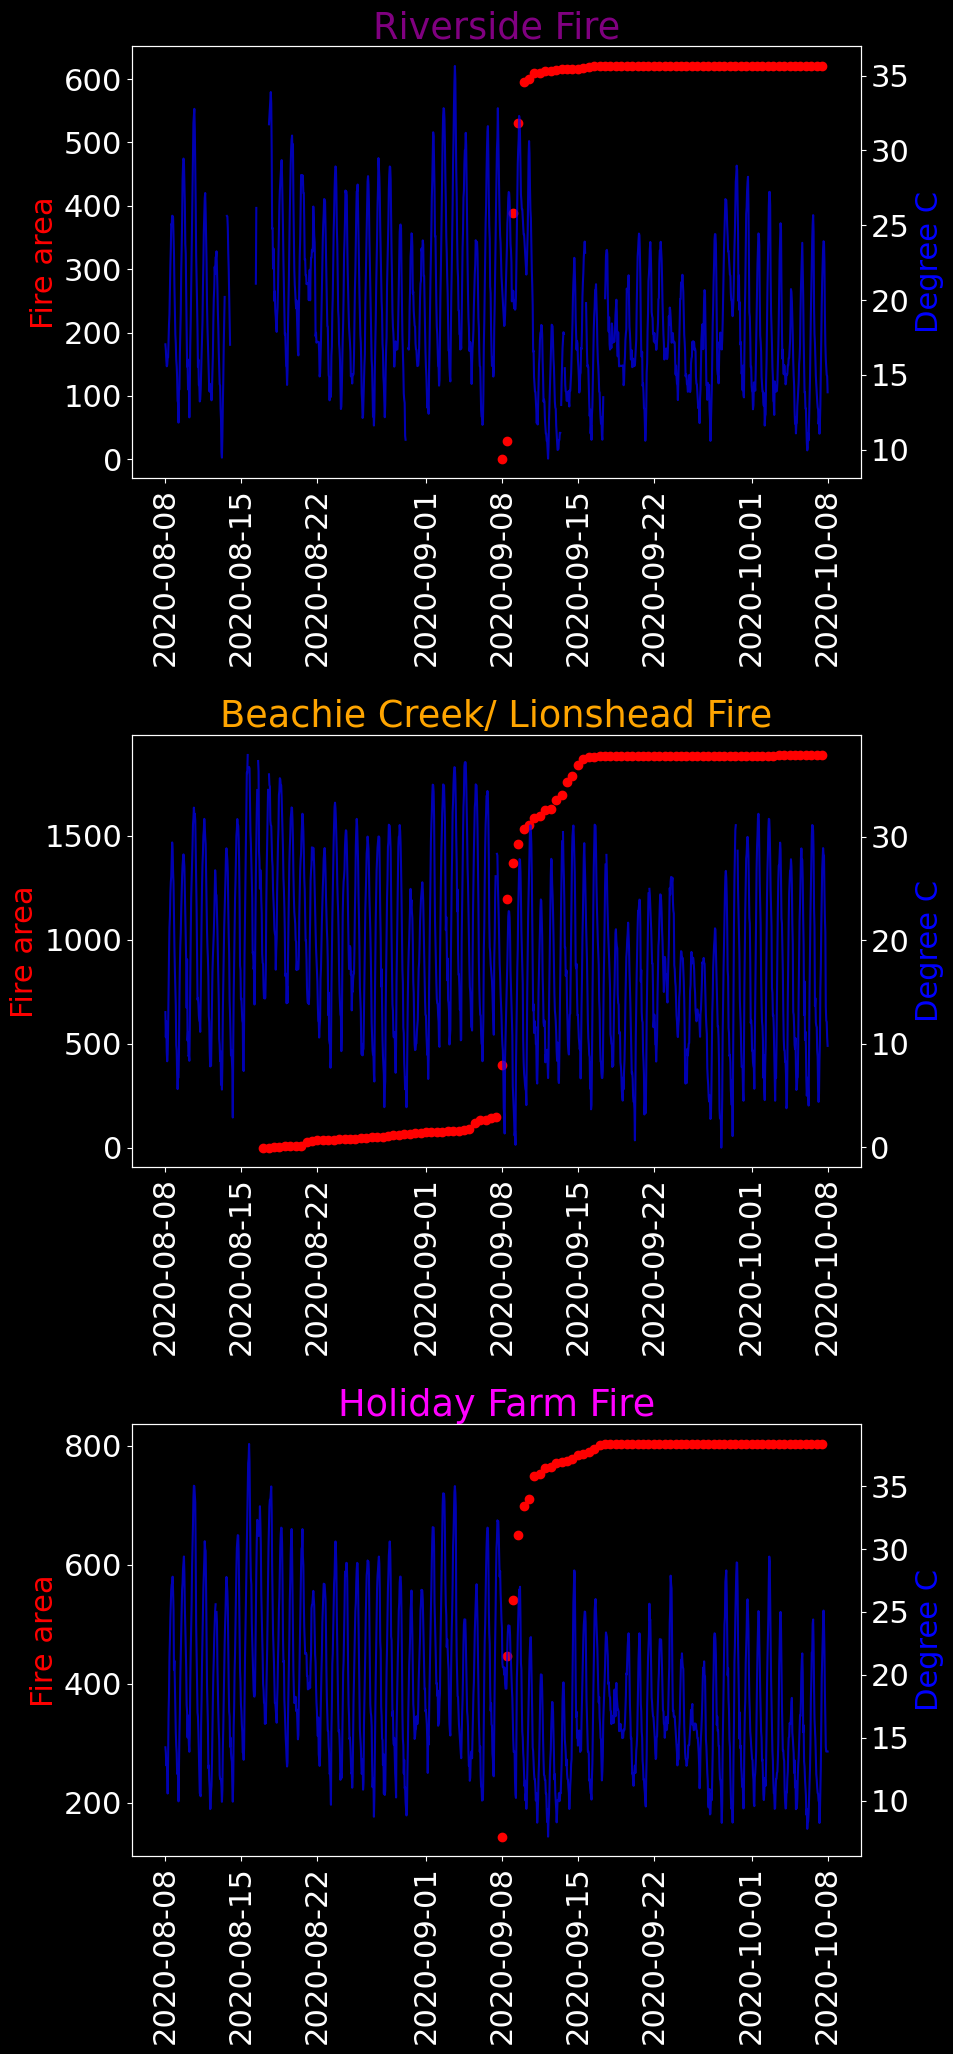

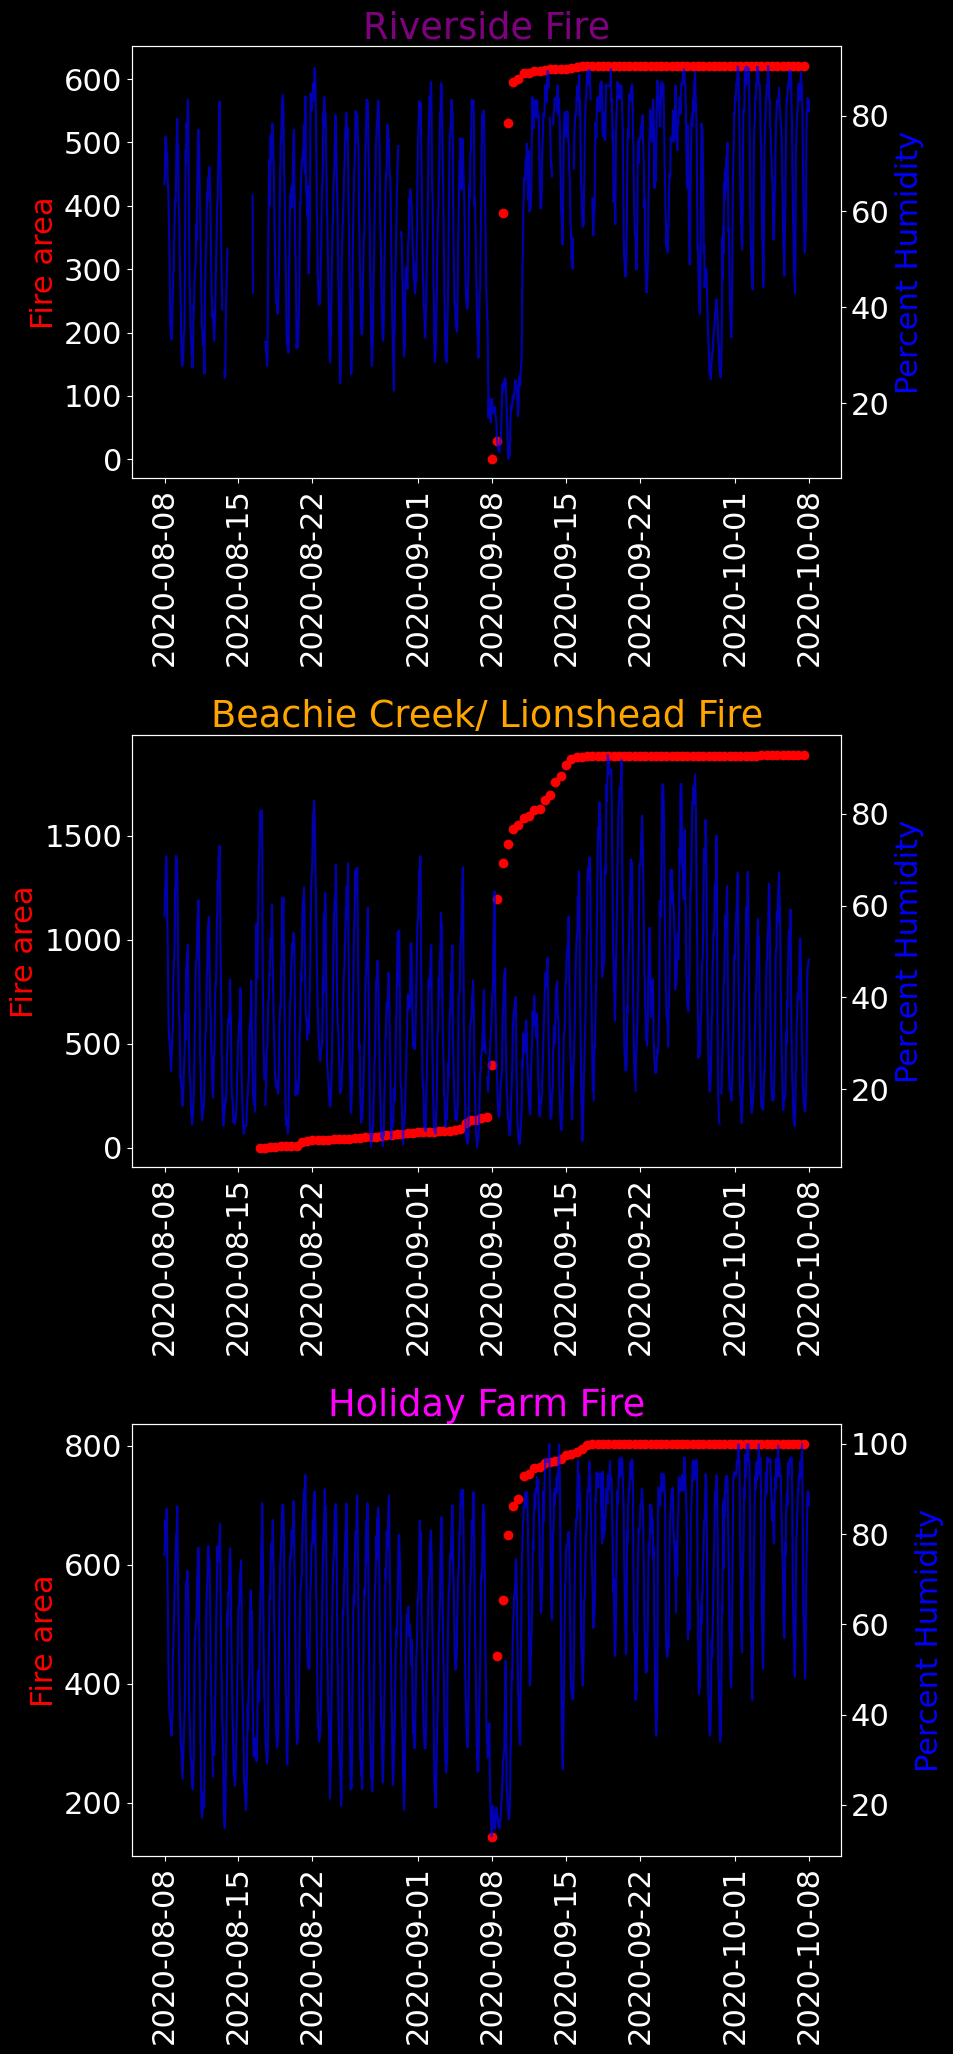

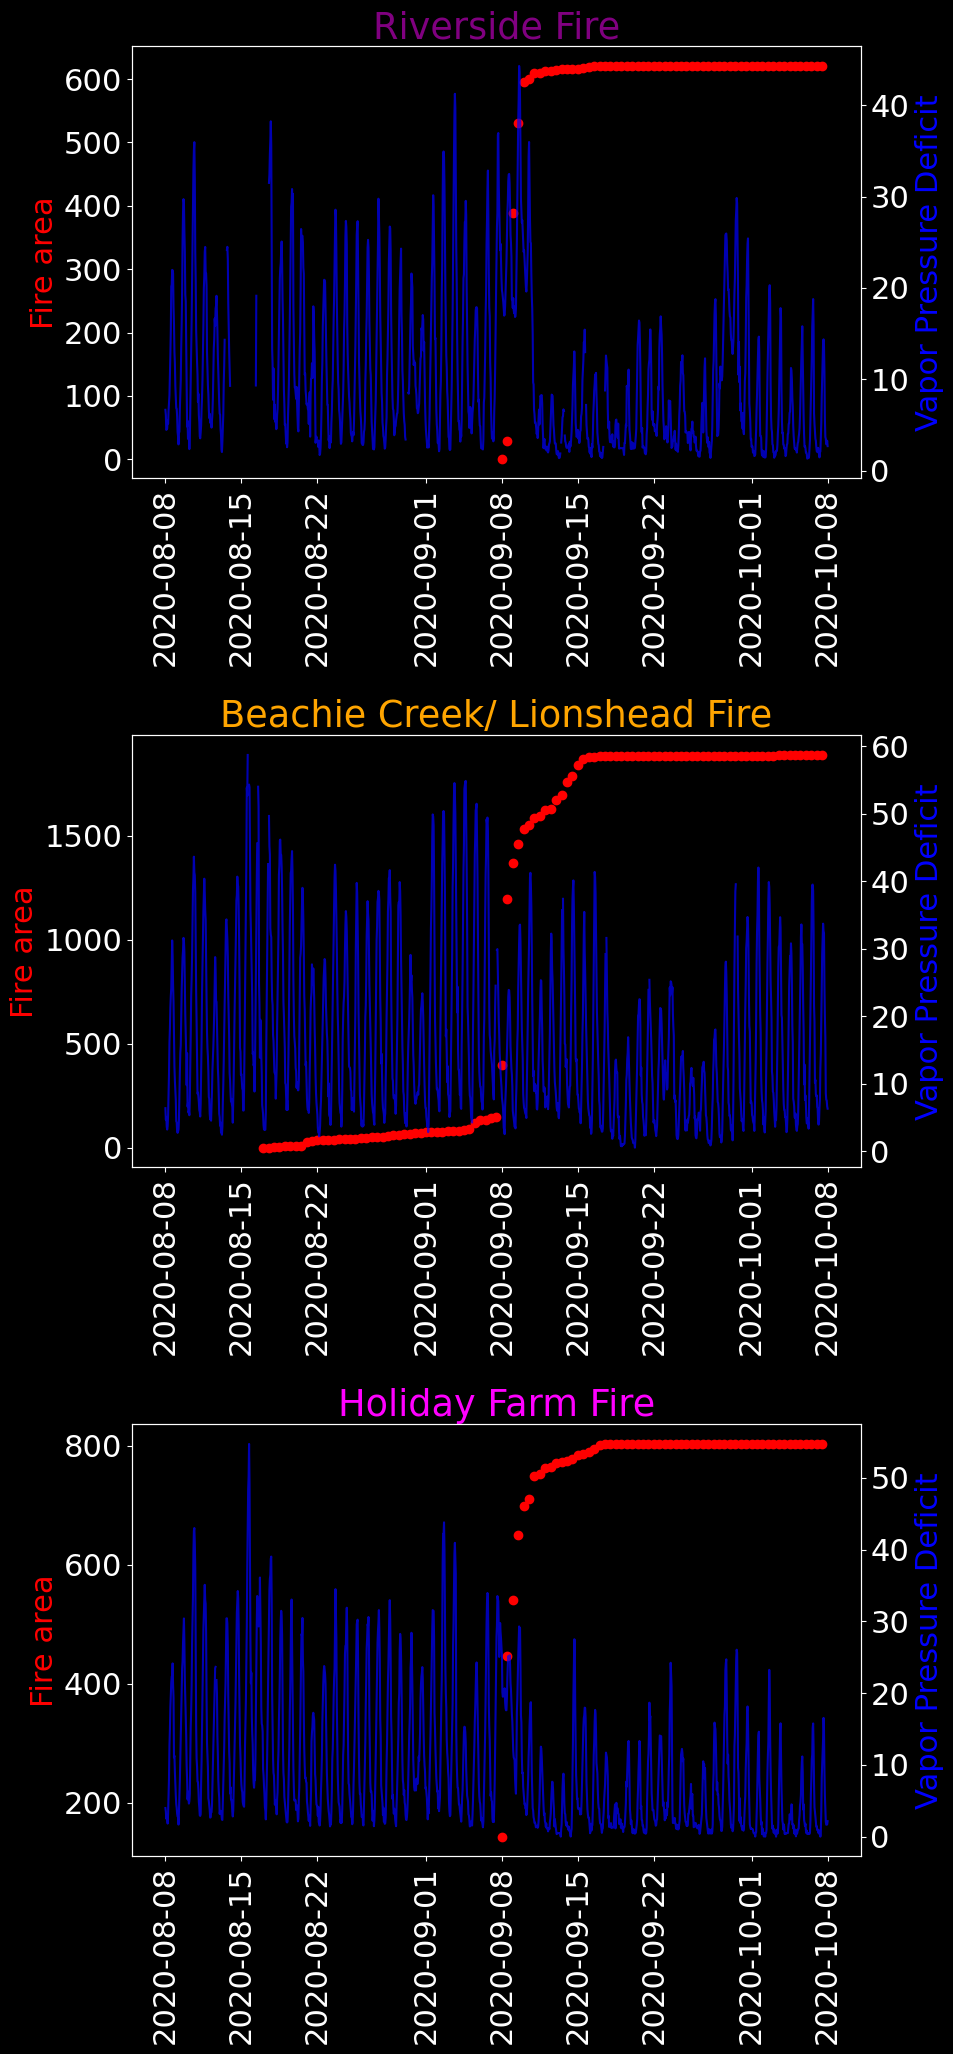

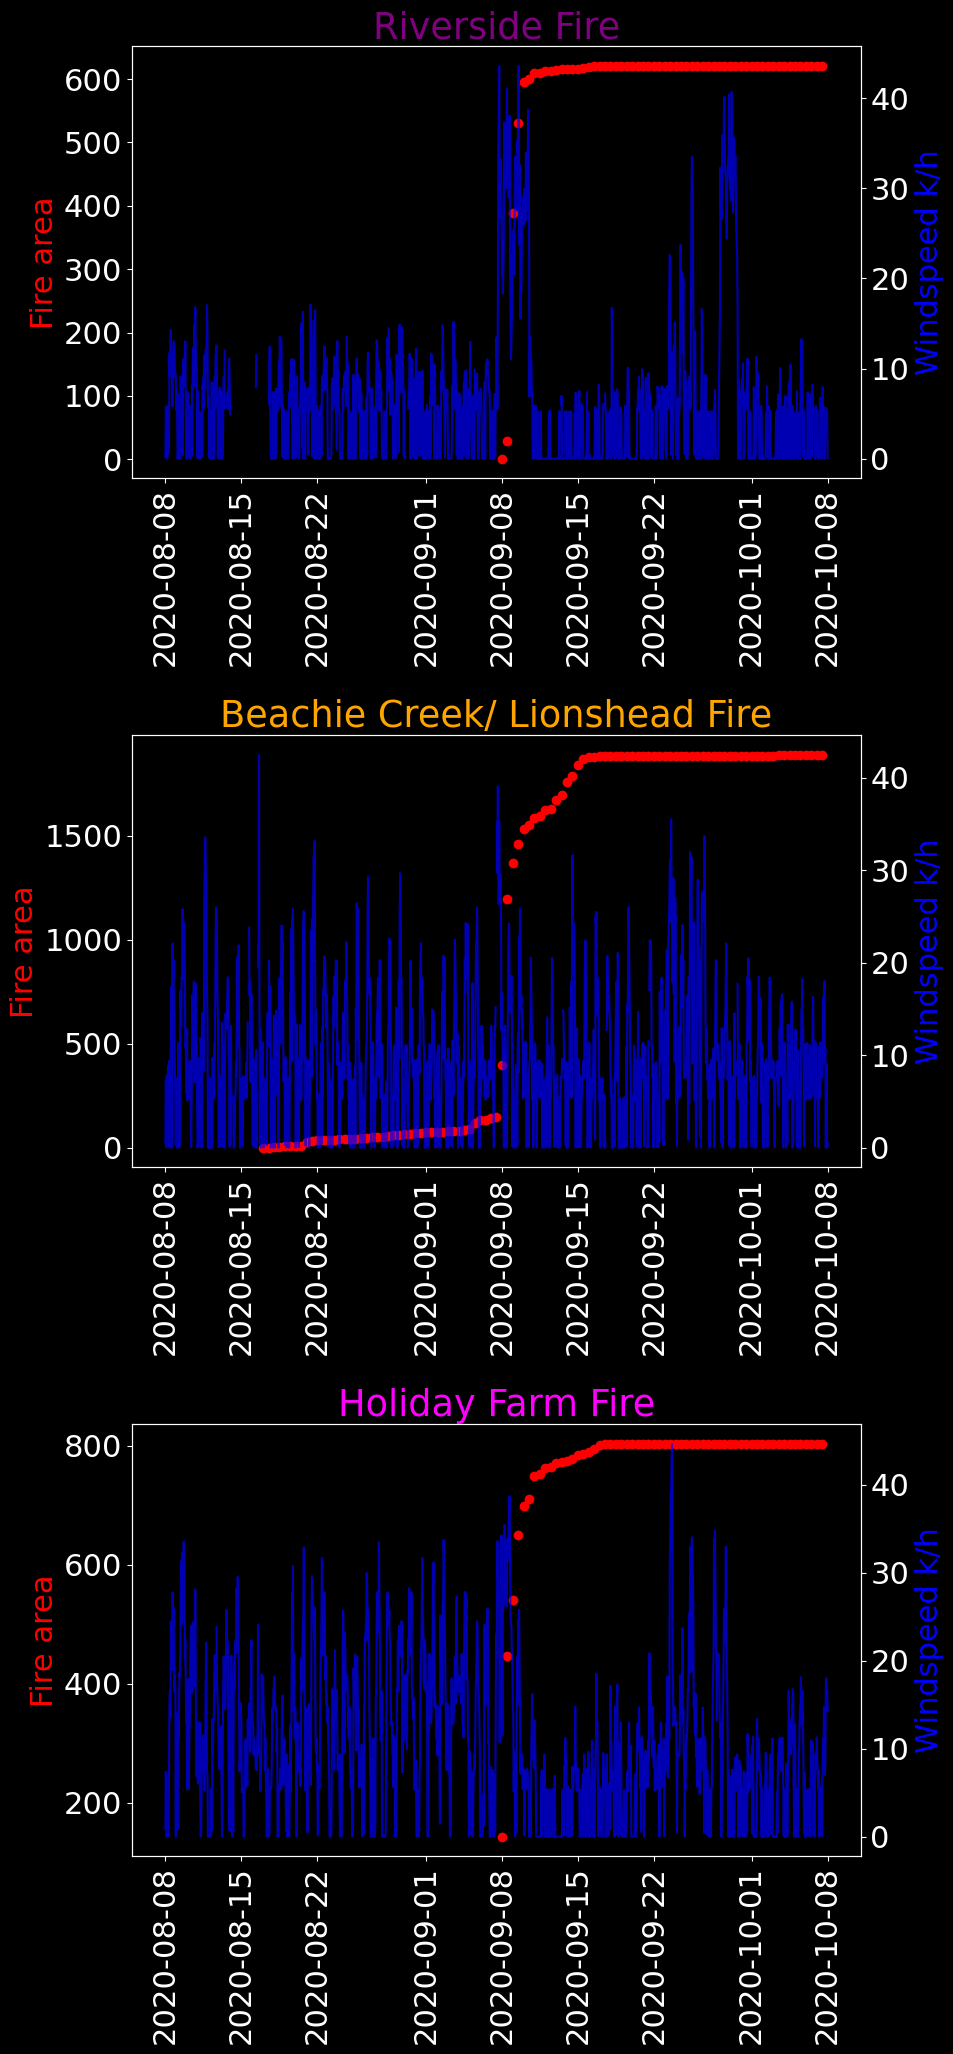

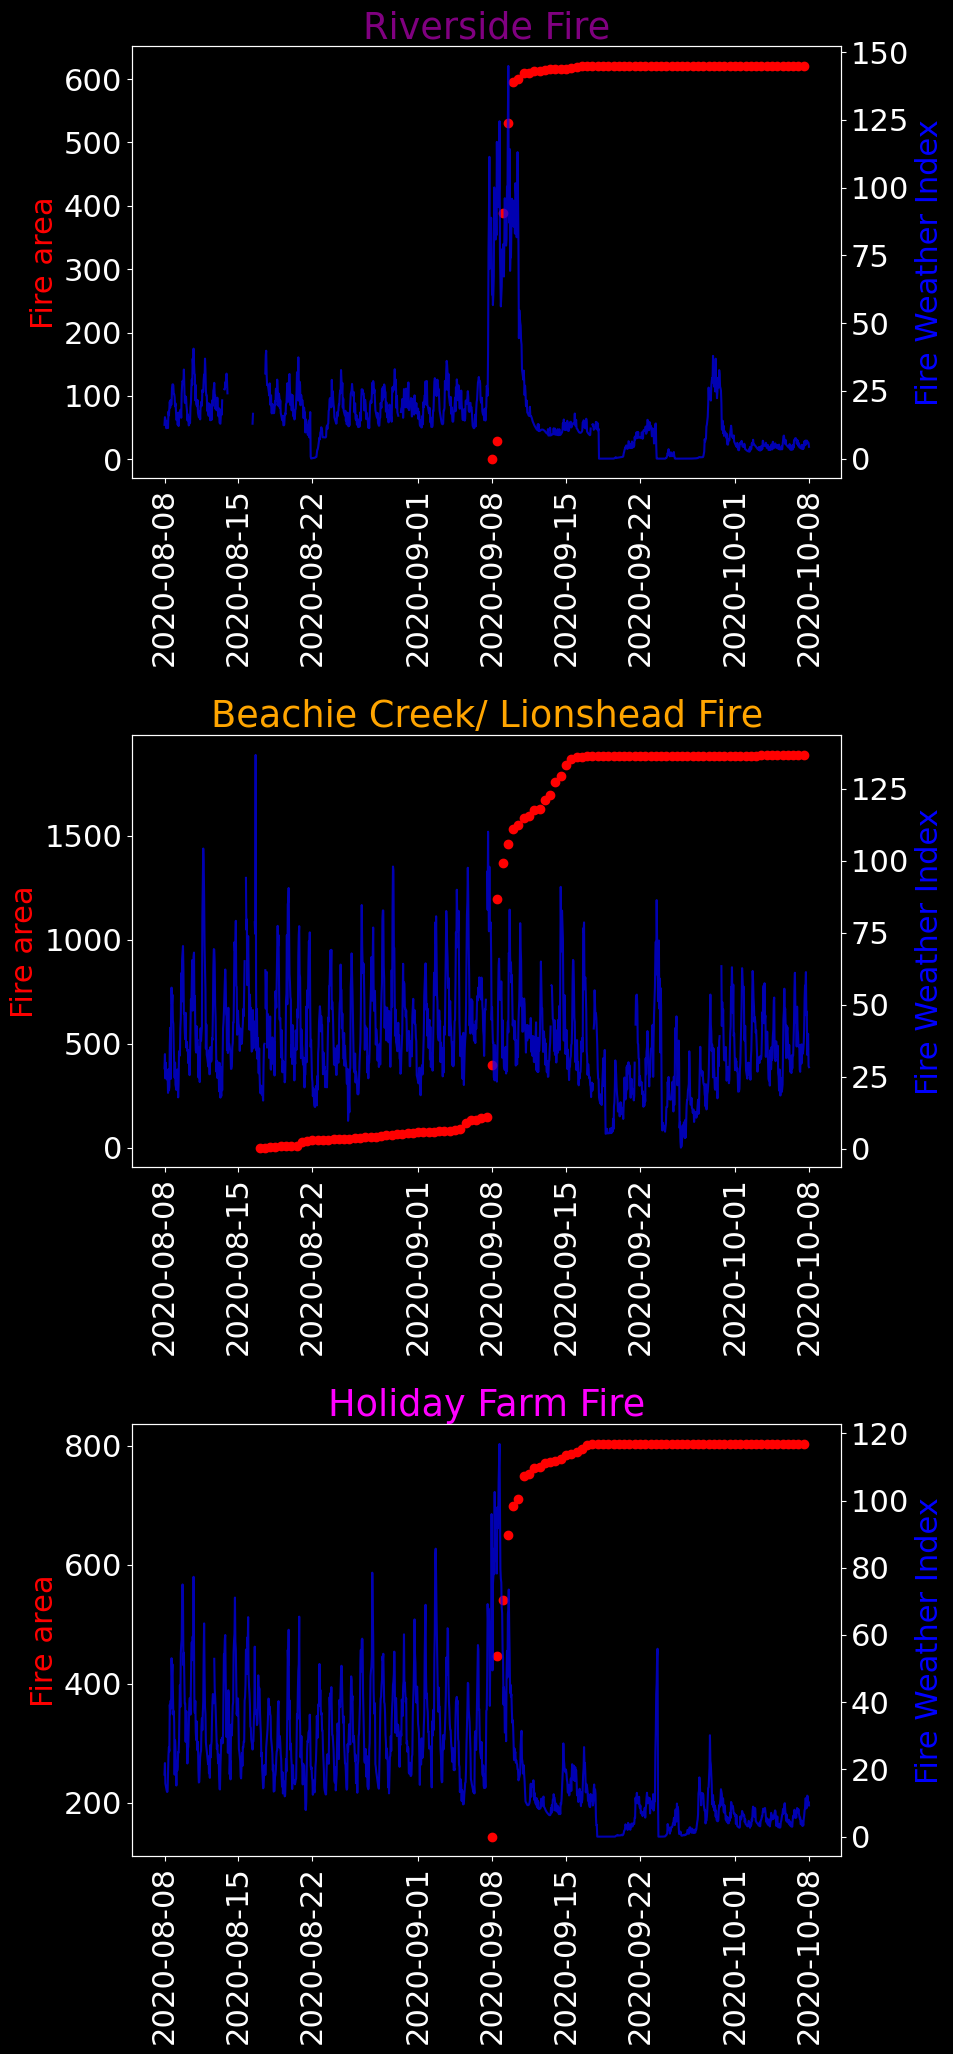

In [17]:
### Putting all the fires on the same axis

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI']  ## Station Data Columns to Plot
met_lab = ["Degree C", "Percent Humidity", "Vapor Pressure Deficit", "Windspeed k/h", "Fire Weather Index"]
fire = [  'farea'] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in range(0, len(met)):
    plt.style.use('dark_background')
    plt.rcParams.update({'font.size': 22})
    for f in fire:
        fif, (ax, ax3, ax5) = plt.subplots(3, figsize=(10,21)) # (ax, ax3, ax5) = plt.subplots(4, figsize=(7,20))
        ## Riverside fire
        ax.scatter(full_fr_riv.t, full_fr_riv["farea"], color = "r") 
        ax.tick_params(axis='x', labelrotation = 90)
        ax.set_title(full_fr_riv.Fire_Name[0] + " Fire", color = "purple")
        ax.set_ylabel("Fire area", color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr_riv["t"], full_fr_riv[met[m]],color="blue",  alpha=0.7)
        ax2.set_ylabel(met_lab[m], color="blue")
        
        
        ## Beachie
        ax3.scatter(full_fr_beach.t, full_fr_beach[f], color = "r")  
        ax3.set_title(full_fr_beach.Fire_Name[0] + " Fire", color = "orange")
        ax3.set_ylabel("Fire area", color = "red")
        ax4=ax3.twinx()
        ax4.plot(full_fr_beach["t"], full_fr_beach[met[m]],color="blue",  alpha=0.7)
        ax4.set_ylabel(met_lab[m], color="blue")
        ax3.tick_params(axis='x', labelrotation = 90)
        
        ## Holiday Farm
        ax5.scatter(full_fr_holi.t, full_fr_holi[f], color = "r")  
        ax5.set_title(full_fr_holi.Fire_Name[0] + " Fire", color = "magenta")
        ax5.set_ylabel("Fire area", color = "red")
        ax6=ax5.twinx()
        ax6.plot(full_fr_holi["t"], full_fr_holi[met[m]],color="blue",  alpha=0.7)
        ax6.set_ylabel(met_lab[m], color="blue")
        ax5.tick_params(axis='x', labelrotation = 90)
        
        
        ## Archie Farm
#         ax7.scatter(full_fr_arch.t, full_fr_arch[f], color = "r")  
#         ax7.set_title(full_fr_arch.Fire_Name[0] + " Fire")
#         ax7.set_ylabel("Fire area", color = "red")
#         ax8=ax7.twinx()
#         ax8.plot(full_fr_arch["t"], full_fr_arch[met[m]],color="blue",  alpha=0.3)
#         ax8.set_ylabel(met_lab[m], color="blue")
#         ax7.tick_params(axis='x', labelrotation = 90)

        plt.subplots_adjust(bottom=0.15)
        plt.tight_layout()
        
        plt.savefig('/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/LIS_visualize/oregon_fires_2020/Fire_Weather_'+ str(m) +'.png', dpi = 450)


        plt.show()

In [53]:
## Plotting all three on the map

gdf_riv.t = gdf_riv.t.astype("str")
import contextily as ctx ## Had to run conda install -c conda-forge contextily after activating the oct4 environment

In [54]:
## Get oregon shapefile 
states = gpd.read_file("/projects/my-public-bucket/fire_weather_vis/ref_data/US_STATES/cb_2018_us_state_500k.shp")




In [55]:
states
oregon = states[states.STUSPS == "OR"]

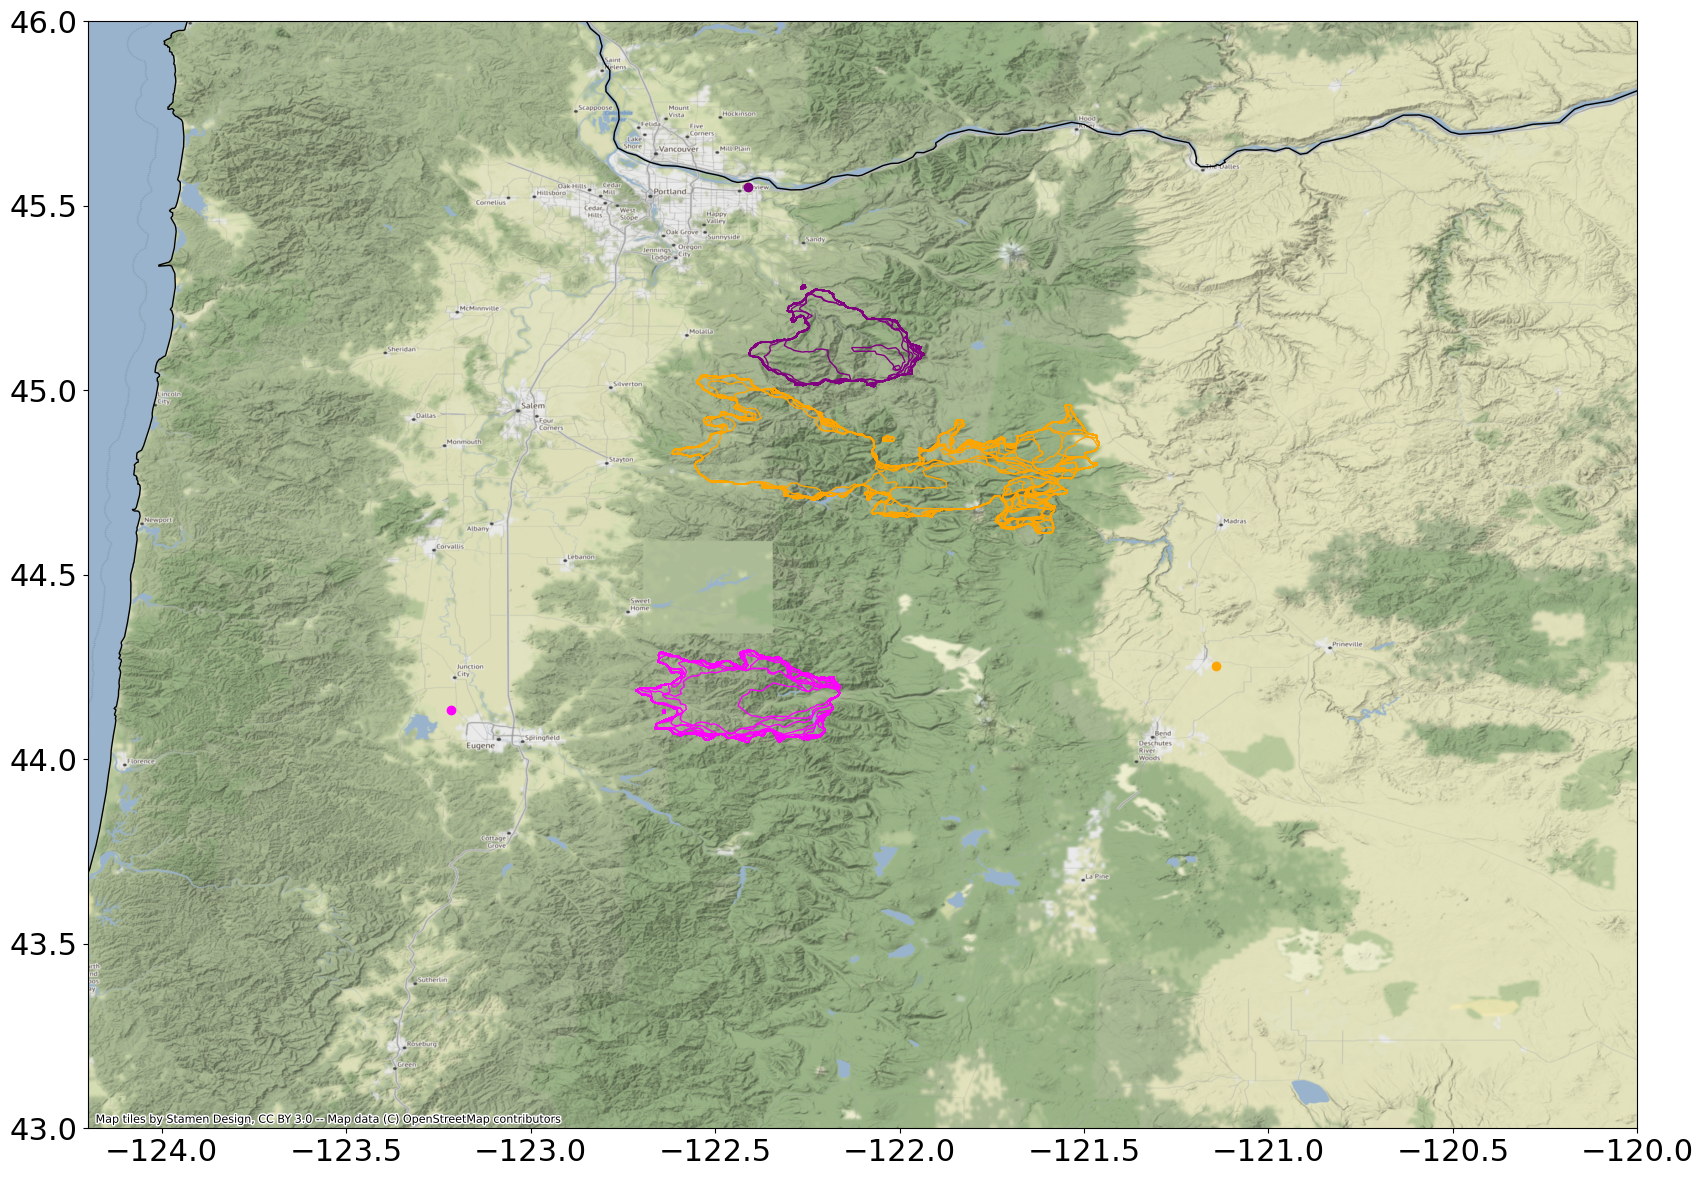

In [56]:
fig, ax = fig, ax = plt.subplots(1, figsize=(17.5, 30))
oregon.plot(ax=ax, facecolor="None", edgecolor='k',alpha=1,linewidth=1)
gdf_riv.plot(ax=ax, facecolor="None", edgecolor='purple',alpha=1,linewidth=1)
ax.scatter(y = 45.551, x = -122.41, color = "purple")

#ax.set_xlabel('Longitude', fontsize=10)
#ax.set_ylabel('Latitude', fontsize='medium')
gdf_beach.plot(ax=ax, facecolor="None", edgecolor='orange',alpha=1,linewidth=1)
ax.scatter(y = 44.254167, x = -121.141, color = "orange") #44.256, -121.141 #44.254167, -121.149722 #44.256 : -121.141
#ax.scatter(y = 44.7805105599346, x = -121.54849958690187, color = "red", marker = "*")
#ax.scatter(y = 44.75, x = -123.216, color = "red", marker = "x")

gdf_holi.plot(ax=ax, facecolor="None", edgecolor='magenta',alpha=1,linewidth=1)
ax.scatter(y = 44.133, x = -123.216, color = "magenta")
#ax.scatter(y = 44.164638475941054, x = -122.41162700397331, color = "magenta", marker = "*")
ctx.add_basemap(ax=ax, crs = gdf_riv.crs, zoom = 10) #source=ctx.providers.Esri.WorldImagery

xlim = (-124.2, -120)
ylim = (43, 46)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
#rect.plot()
#gdf.plot()
plt.tight_layout()
#plt.savefig('/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/LIS_visualize/oregon_fires_2020/Three_fire_on_map.jpg', dpi = 500)
plt.show()

In [57]:
geos_fwi = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")



In [58]:
g_fwi  = geos_fwi["GPM.LATE.v5_FWI"]



min_lat = 43
max_lat = 46
min_lon = -124.2 
max_lon = -20

gsmall = g_fwi.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
gffmc = geos_fwi["GPM.LATE.v5_FFMC"]
gisi = geos_fwi["GPM.LATE.v5_ISI"]
gdc = geos_fwi["GPM.LATE.v5_DC"]
gdmc = geos_fwi["GPM.LATE.v5_DMC"]

In [59]:
dates = pd.date_range("2020-09-04", "2020-09-11", freq = "1D")
print(len(dates))

8


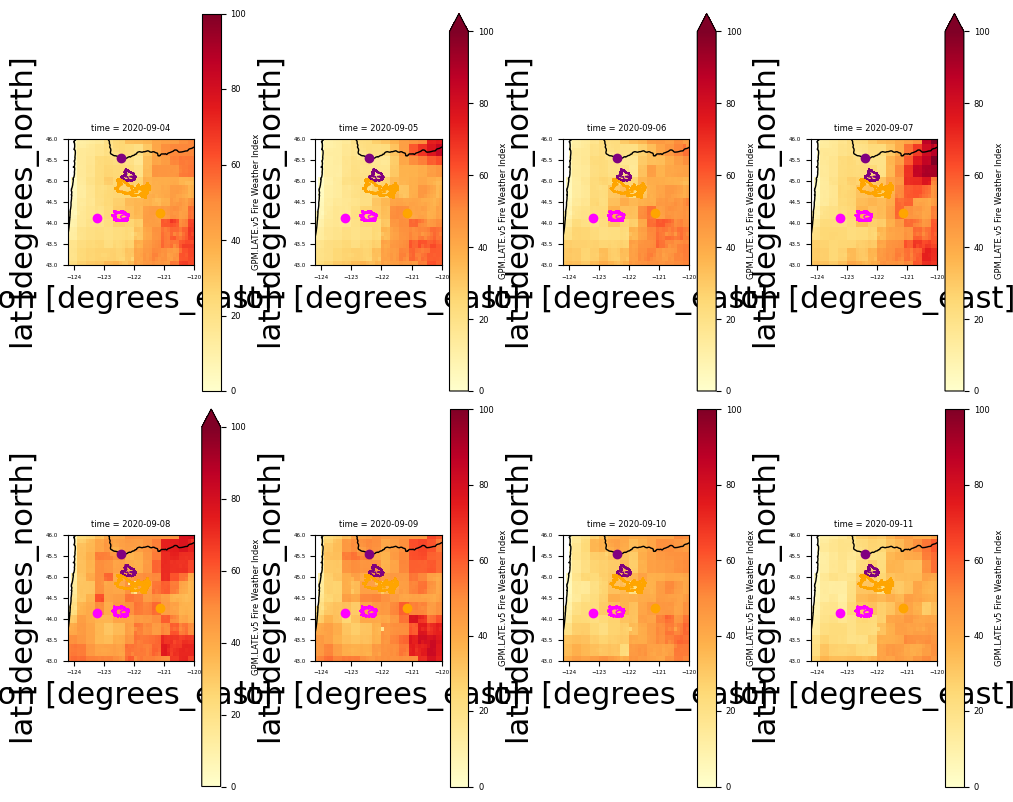

In [60]:
xlim = (-124.2, -120)
ylim = (43, 46)


fig, ax = plt.subplots(2,4, figsize=(10, 8)) #figsize=(10, 8), ax = fig,
fig.subplots_adjust(hspace = .5, wspace=.001)
ax = ax.ravel()
plt.rcParams.update({'font.size': 6})
plt.rcParams.update({'axes.titlesize': 6})


for n, d in enumerate(dates):
    
    #print(type(ax))

    ax[n].tick_params(axis='both', labelsize=4)
    gsmall.sel(time = d).plot(ax = ax[n], cmap = "YlOrRd", vmin = 0,vmax = 100, label = " ")
    oregon.plot(ax=ax[n], facecolor="None", edgecolor='k',alpha=1,linewidth=1)
    gdf_riv.plot(ax=ax[n], facecolor="None", edgecolor='purple',alpha=1,linewidth=1)
    ax[n].scatter(y = 45.551, x = -122.41, color = "purple")

    #ax.set_xlabel('Longitude', fontsize=10)
    #ax.set_ylabel('Latitude', fontsize='medium')
    gdf_beach.plot(ax=ax[n], facecolor="None", edgecolor='orange',alpha=1,linewidth=1)
    ax[n].scatter(y = 44.254167, x = -121.141, color = "orange") #44.256, -121.141 #44.254167, -121.149722 #44.256 : -121.141
    #ax.scatter(y = 44.7805105599346, x = -121.54849958690187, color = "red", marker = "*")
    #ax.scatter(y = 44.75, x = -123.216, color = "red", marker = "x")

    gdf_holi.plot(ax=ax[n], facecolor="None", edgecolor='magenta',alpha=1,linewidth=1)
    ax[n].scatter(y = 44.133, x = -123.216, color = "magenta")
    #ax.scatter(y = 44.164638475941054, x = -122.41162700397331, color = "magenta", marker = "*")
    #ctx.add_basemap(ax=ax, crs = gdf_riv.crs, zoom = 10) #source=ctx.providers.Esri.WorldImagery

    

    ax[n].set_xlim(xlim)
    ax[n].set_ylim(ylim)
    #rect.plot()
    #gdf.plot()
plt.tight_layout()
plt.show()
    

In [61]:
enumerate(dates)

In [62]:
gsmall_riv = gsmall.sel(lat = 45.551, lon = -122.41, method = "nearest")
gsmall_beach = gsmall.sel(lat = 44.254167, lon = -121.141, method = "nearest")
gsmall_holi = gsmall.sel(lat = 44.133, lon = -123.216, method = "nearest")


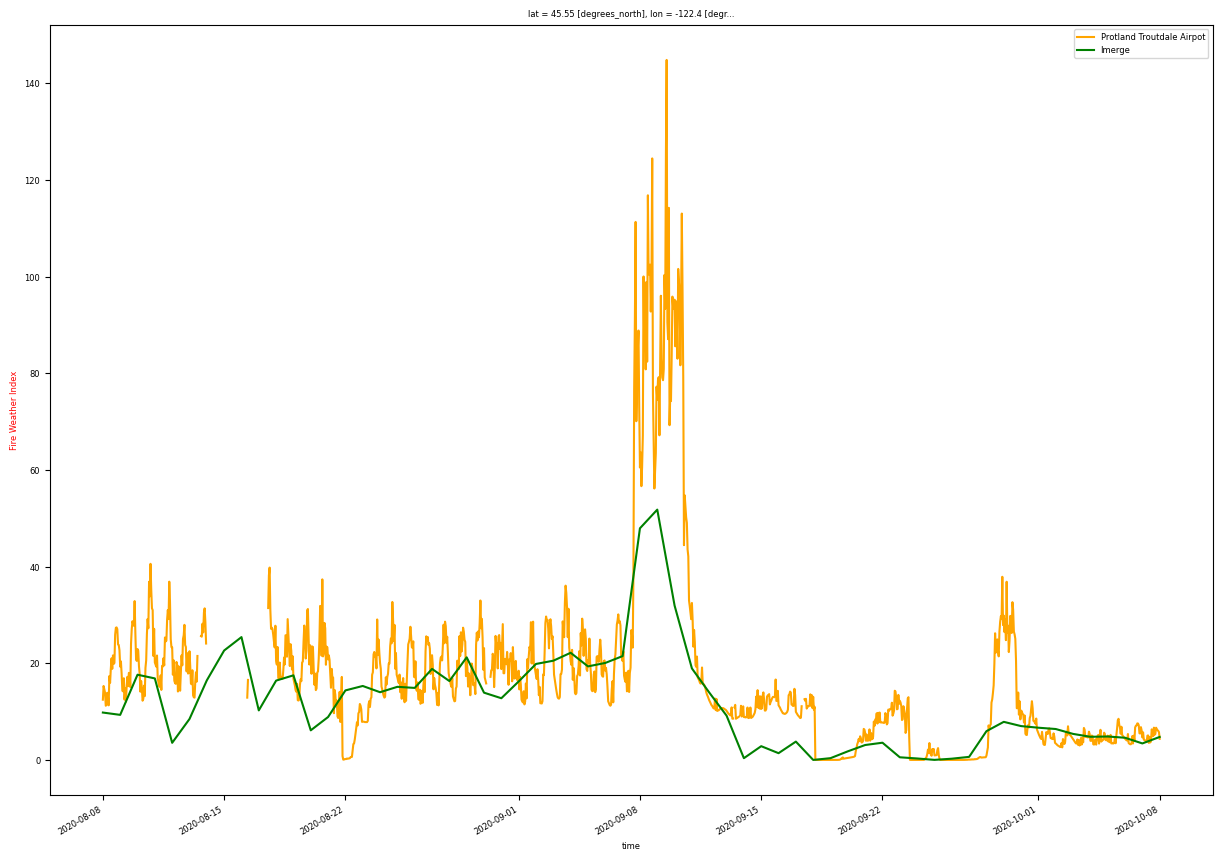

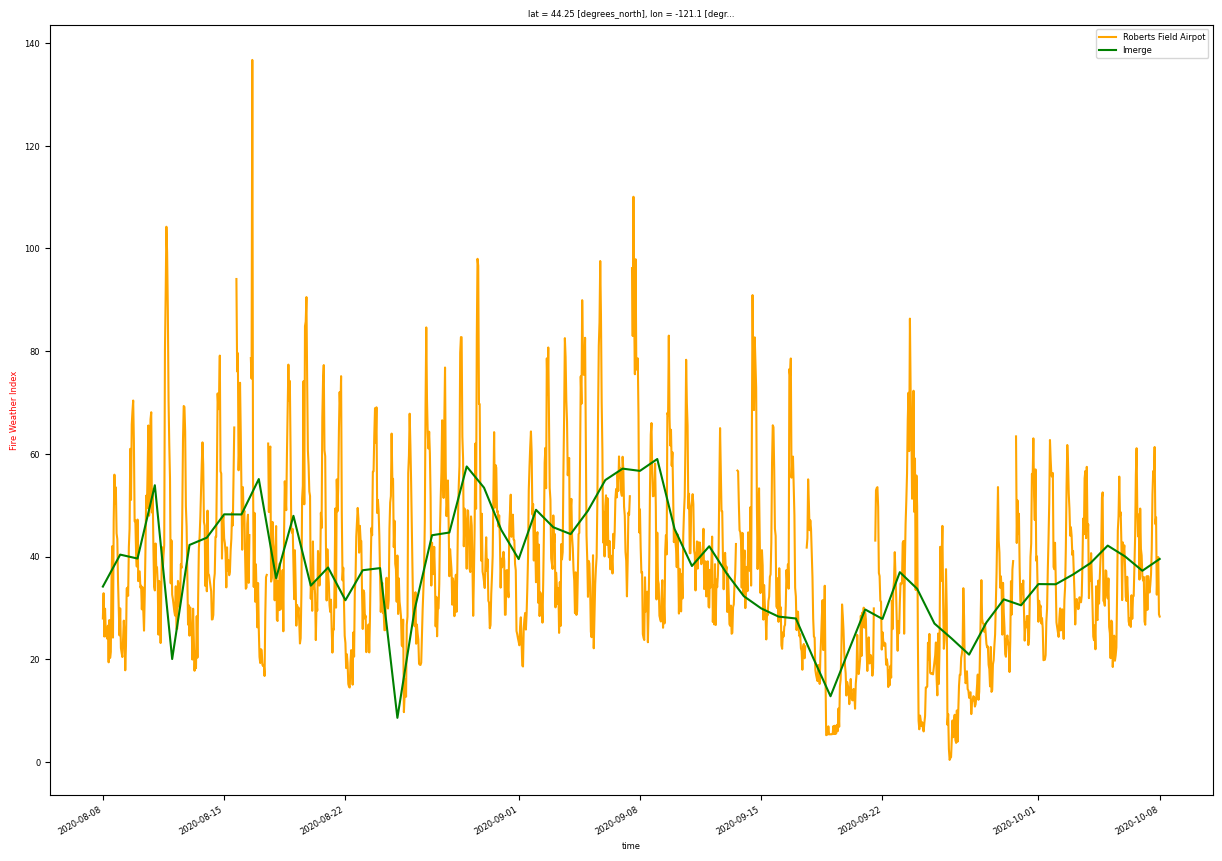

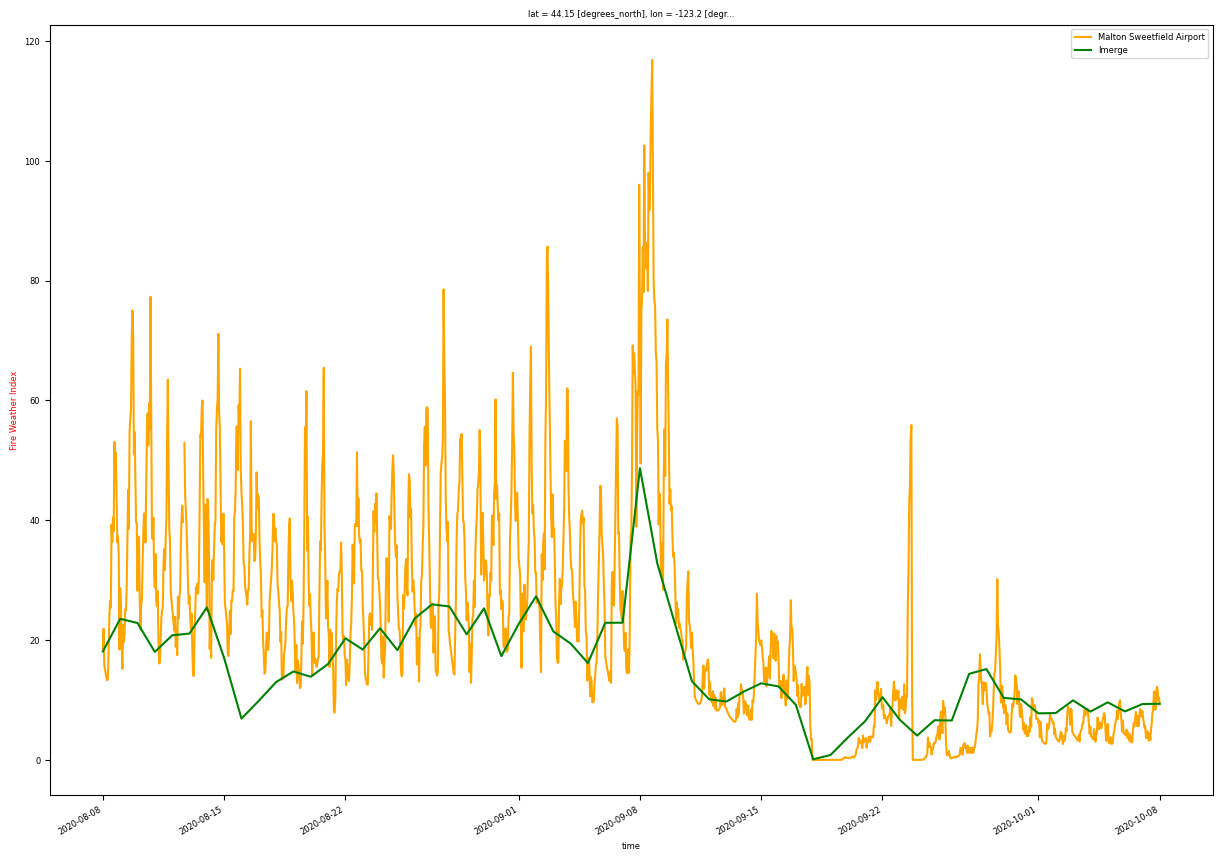

In [63]:
full_fr_st = [full_fr_riv, full_fr_beach, full_fr_holi]
gsmall_st = [gsmall_riv, gsmall_beach, gsmall_holi]
labs = ["Protland Troutdale Airpot", "Roberts Field Airpot", "Malton Sweetfield Airport"]


## All timeseries on one plot
for i in range(0, len(labs)):
    
    f, (ax) = plt.subplots(1, figsize =(15,10))

    ax.plot(full_fr_st[i].t, full_fr_st[i].FWI, color = "orange", label = labs[i])  # c = full_fr.FWI, cmap = "bwr", vmin = 0, vmax = 100
    gsmall_st[i].sel(time = slice("2020-08-08", "2020-10-08")).plot(color = "green", label = "Imerge")
    ax.legend()
    ax.set_ylabel("Fire Weather Index",color="red")

In [64]:
## Checking out IMERGE anomolies for each of these fires.
imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")

In [65]:
#final_perimeter = gdf_riv[gdf_riv.t == max(gdf_riv.t)].geometry
#type(final_perimeter.geometry.)
len(gdf_riv)

final_perimeter = gdf_riv.iloc[len(gdf_riv) -1].geometry
min_box = final_perimeter.minimum_rotated_rectangle.exterior.coords.xy

min_lon = min(min_box[0])
max_lon = max(min_box[0])


print(min_box[0])
min_lon

array('d', [-122.41646905135397, -122.0351943223663, -121.92416706844139, -122.30544179742907, -122.41646905135397])


-122.41646905135397

In [66]:
#type(imerge)

img_clp = imerge.sel(lat = slice(min(min_box[1]), max(min_box[1])), lon = slice(min(min_box[0]), max(min_box[0]) ))
#imerge = imerge.rio.set_spatial_dims("lon", "lat")
#imerge = imerge.rio.write_crs("4326")
#final_perimeter.set_crs("EPSG:4326")
#imerge = imerge.rio.set_crs("EPSG:4326")
#img_clip = imerge["GPM.LATE.v5_BUI"].rio.clip(final_perimeter, crs ="epsg:4326" , from_disk = True)
#img_clip = fv.imerge_climate(imerge ,clim = ["rank_anomolie"], var = ["FWI"])
#?imerge.rio.clip
#imerge

In [67]:
#img_clp

In [68]:
img_clp = fv.imerge_climate(img_clp ,clim = ["rank_anomolie"], var = ["FWI"])


Assignign variable FWI_anomolie
Assignign variable FWI_rank_anomolies


In [69]:
img_means = img_clp.mean(dim=["lat", "lon"])
img_means

<xarray.Dataset>
Dimensions:             (time: 3200)
Coordinates:
  * time                (time) datetime64[ns] 2014-05-01 ... 2023-02-02
Data variables:
    GPM.LATE.v5_BUI     (time) float32 9.156 10.47 11.54 7.817 ... nan nan nan
    GPM.LATE.v5_DC      (time) float32 21.56 26.14 30.22 24.78 ... nan nan nan
    GPM.LATE.v5_DMC     (time) float32 9.186 10.44 11.04 6.464 ... nan nan nan
    GPM.LATE.v5_DSR     (time) float32 0.2165 0.3181 0.2524 ... nan nan nan
    GPM.LATE.v5_FFMC    (time) float32 87.08 85.93 82.36 44.95 ... nan nan nan
    GPM.LATE.v5_FWI     (time) float32 3.213 3.999 3.392 0.1424 ... nan nan nan
    GPM.LATE.v5_ISI     (time) float32 3.245 3.645 3.008 0.256 ... nan nan nan
    FWI_anomolie        (time) float32 -5.724 -6.381 -6.988 ... nan nan nan
    FWI_rank_anomolies  (time) float64 1.012e+03 846.3 797.3 ... nan nan nan

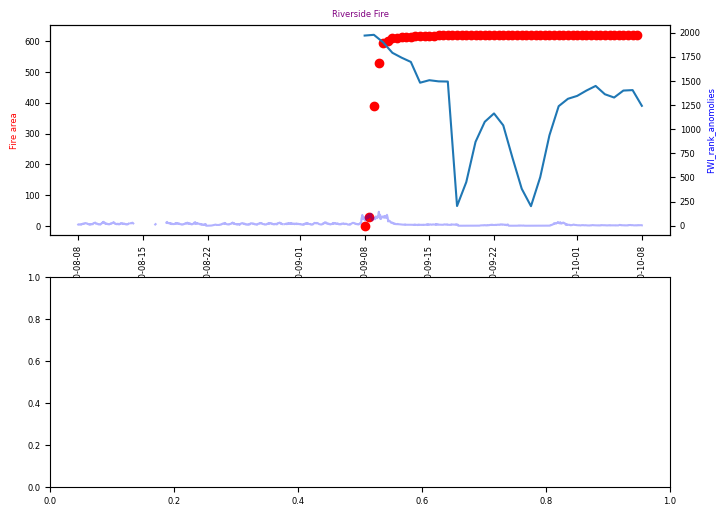

In [70]:
met = ['FWI']  ## Station Data Columns to Plot
met_lab = ["Fire Weather Index"]
fire = [  'farea'] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in range(0, len(met)):
    for f in fire:
        fif, (ax, ax3) = plt.subplots(2, figsize=(8,6)) # (ax, ax3, ax5) = plt.subplots(4, figsize=(7,20))
        ## Riverside fire
        ax.scatter(full_fr_riv.t, full_fr_riv["farea"], color = "r") 
        ax.tick_params(axis='x', labelrotation = 90)
        ax.set_title(full_fr_riv.Fire_Name[0] + " Fire", color = "purple")
        ax.set_ylabel("Fire area", color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr_riv["t"], full_fr_riv[met[m]],color="blue",  alpha=0.3)
        ax2.set_ylabel(met_lab[m], color="blue")
        
        ## Riverside fire IMERGE
        #ax3.scatter(full_fr_riv.t, full_fr_riv["farea"], color = "r") 
        #ax3.tick_params(axis='x', labelrotation = 90)
        #ax3.set_title(full_fr_riv.Fire_Name[0] + " Fire", color = "purple")
        #ax3.set_ylabel("Fire area", color = "red")
        #ax4=ax3.twinx()
        img_means["FWI_rank_anomolies"].sel(time = slice(full_fr_riv.t[0], full_fr_riv.t[len(full_fr_riv.t) -1])).plot()
        #ax4.plot(, full_fr_riv[met[m]],color="blue",  alpha=0.3)
        #ax4.set_ylabel(met_lab[m], color="blue")
        



        plt.show()